#Loading libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

#Reading data and some descriptive stats

In [ ]:
df=pd.read_csv('mobiledata.csv')

In [ ]:
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [ ]:
df.shape

(2000, 21)

In [ ]:
df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,9.916500,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,6.064315,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,5.000000,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,10.000000,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,15.000000,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [ ]:
df.groupby('price_range').size()

price_range
0    500
1    500
2    500
3    500
dtype: int64

Unimodal data visualisation

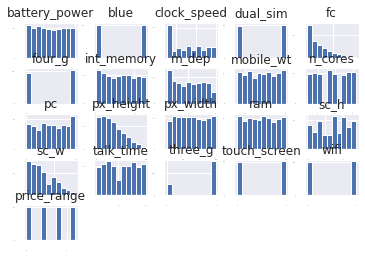

In [ ]:
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
plt.show()

# Data preprocessing

In [ ]:
def preprocess_input(df):
  df['px_area'] = df['px_width'] * df['px_height'] / (1024**2)
  df['battery_per_core'] = df['battery_power']/ df['n_cores']
  df['speed_per_core'] = df['clock_speed']/ df['n_cores']
  df['battery_per_ram'] = df['battery_power']/ df['ram']
  df['speed_per_ram'] = df['clock_speed']/ df['ram']
  df['battery_talk'] = df['battery_power']/ df['talk_time']
  df['memory_per_ram'] = df['int_memory']* 1024 / (df['ram'])
  return df


In [ ]:
df_processed = preprocess_input(df)
df_processed

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range,px_area,battery_per_core,speed_per_core,battery_per_ram,speed_per_ram,battery_talk,memory_per_ram
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1,0.014420,421.000000,1.100000,0.330326,0.000863,44.315789,2.812083
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2,1.715794,340.333333,0.166667,0.388065,0.000190,145.857143,20.627898
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2,2.066906,112.600000,0.100000,0.216289,0.000192,62.555556,16.129082
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2,2.071167,102.500000,0.416667,0.222102,0.000903,55.909091,3.698086
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1,1.396271,910.500000,0.600000,1.290574,0.000850,121.400000,31.931963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,14,1222,1890,668,13,4,19,1,1,0,0,2.202587,132.333333,0.083333,1.188623,0.000749,41.789474,3.065868
1996,1965,1,2.6,1,0,0,39,0.2,187,4,3,915,1965,2032,11,10,16,1,1,1,2,1.714683,491.250000,0.650000,0.967028,0.001280,122.812500,19.653543
1997,1911,0,0.9,1,1,1,36,0.7,108,8,3,868,1632,3057,9,1,5,1,1,0,3,1.350952,238.875000,0.112500,0.625123,0.000294,382.200000,12.058881
1998,1512,0,0.9,0,4,1,46,0.1,145,5,5,336,670,869,18,10,19,1,1,1,0,0.214691,302.400000,0.180000,1.739931,0.001036,79.578947,54.204833


In [ ]:
df_processed[df_processed.px_width == 0]['px_width'] = df_processed[df_processed.px_width != 0].mean()

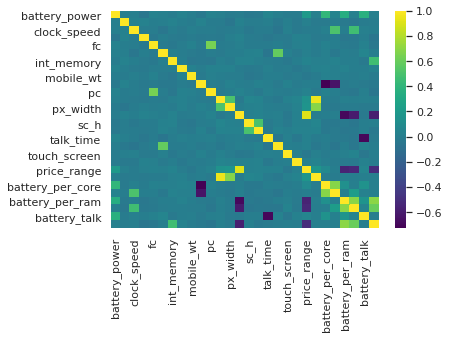

In [ ]:
sns.heatmap(df_processed.corr(), cmap= 'viridis')

In [ ]:
y = df_processed['price_range']
X = df_processed.drop('price_range', axis = 1)

In [ ]:
cat_cols = ['blue','dual_sim','four_g','three_g','touch_screen','wifi']

num_cols = ['battery_power','clock_speed','fc','int_memory','m_dep','mobile_wt',
            'n_cores','pc','px_height','px_width','ram','sc_h','sc_w',
            'talk_time', 'px_area', 'battery_per_core', 'speed_per_core',
            'battery_per_ram','speed_per_ram','battery_talk','memory_per_ram']

# Model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline as mp
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn_pandas import DataFrameMapper

def get_stacking_model():
  mapper = DataFrameMapper([(continuous_col, StandardScaler()) for continuous_col in num_cols])
  level0 = []
  level0.append(('knn', mp(mapper, KNeighborsClassifier(n_neighbors = 13))))
  level0.append(('svm', mp(mapper, SVC(C = 2e3) ))))
  level0.append(('rf', RandomForestClassifier(n_estimators = 500, criterion= 'entropy', min_samples_leaf= 2, max_features= 0.6) ) )
  level0.append(('et', ExtraTreesClassifier(n_estimators = 1000, criterion= 'entropy', max_features= 0.5) ) )
  level0.append(('gb', GradientBoostingClassifier(n_estimators = 500, learning_rate= 0.05, max_features= 0.5, min_samples_leaf= 0.1) ) )
  # define meta learner model
  level1 = KNeighborsClassifier(n_neighbors = 11)
  # define the stacking ensemble
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=1))
  return model

In [ ]:
model = get_stacking_model()
model.fit(X, y)
print('Mean cross validation accuracy: %.2f %%' % (model.score(X, y)* 100))

Mean cross validation accuracy: 99.50 %


In [ ]:
import joblib
filename = 'final_model.sav'
joblib.dump(model, filename)

['final_model.sav']

In [ ]:
import joblib
filename = 'final_model.sav'
model = joblib.load(filename)

In [ ]:
model.score(X, y)

0.995

In [ ]:
X

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,px_area,battery_per_core,speed_per_core,battery_per_ram,speed_per_ram,battery_talk,memory_per_ram
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,0.014420,421.000000,1.100000,0.330326,0.000863,44.315789,2.812083
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,1.715794,340.333333,0.166667,0.388065,0.000190,145.857143,20.627898
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2.066906,112.600000,0.100000,0.216289,0.000192,62.555556,16.129082
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2.071167,102.500000,0.416667,0.222102,0.000903,55.909091,3.698086
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1.396271,910.500000,0.600000,1.290574,0.000850,121.400000,31.931963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,14,1222,1890,668,13,4,19,1,1,0,2.202587,132.333333,0.083333,1.188623,0.000749,41.789474,3.065868
1996,1965,1,2.6,1,0,0,39,0.2,187,4,3,915,1965,2032,11,10,16,1,1,1,1.714683,491.250000,0.650000,0.967028,0.001280,122.812500,19.653543
1997,1911,0,0.9,1,1,1,36,0.7,108,8,3,868,1632,3057,9,1,5,1,1,0,1.350952,238.875000,0.112500,0.625123,0.000294,382.200000,12.058881
1998,1512,0,0.9,0,4,1,46,0.1,145,5,5,336,670,869,18,10,19,1,1,1,0.214691,302.400000,0.180000,1.739931,0.001036,79.578947,54.204833


In [ ]:
ypred = model.predict(X)
from sklearn.metrics import confusion_matrix
confusion_matrix(ypred, y)

array([[500,   1,   0,   0],
       [  0, 497,   2,   0],
       [  0,   2, 496,   3],
       [  0,   0,   2, 497]])

# Testing the predictions

In [ ]:
i = {'batCap': '510', 'clkSpeed': '2', 'intMem': '45', 'pc': '16', 'fc': '5', 
     'mobDepth': '0.9', 'mobWeight': '168', 'pxh': '483', 'pxw': '754', 'sh': '19', 
     'sw': '4', 'tt': '2', 'cpuCores': 6, 'blu': True, 'dsim': True, 'ram': '3919',
     'fourg': True, 'threeg': True, 'wif': True, 'tou': True}

i.values()

dict_values(['510', '2', '45', '16', '5', '0.9', '168', '483', '754', '19', '4', '2', 6, True, True, '3919', True, True, True, True])

In [ ]:
df_cols = ['battery_power','blue','clock_speed','dual_sim','fc','four_g',
           'int_memory','m_dep','mobile_wt','n_cores','pc','px_height',
           'px_width','ram','sc_h','sc_w','talk_time','three_g',
           'touch_screen','wifi']

dict_cols = ['batCap', 'blu', 'clkSpeed', 'dsim', 'fc', 'fourg', 
             'intMem', 'mobDepth', 'mobWeight', 'cpuCores', 'pc',
             'pxh', 'pxw', 'ram', 'sh', 'sw', 'tt', 'threeg',
             'tou', 'wif']

In [ ]:
a = {col: 1 for col in df_cols}
a

{'battery_power': 1,
 'blue': 1,
 'clock_speed': 1,
 'dual_sim': 1,
 'fc': 1,
 'four_g': 1,
 'int_memory': 1,
 'm_dep': 1,
 'mobile_wt': 1,
 'n_cores': 1,
 'pc': 1,
 'px_height': 1,
 'px_width': 1,
 'ram': 1,
 'sc_h': 1,
 'sc_w': 1,
 'talk_time': 1,
 'three_g': 1,
 'touch_screen': 1,
 'wifi': 1}

In [ ]:
def get_prediction(X_in):
  d = pd.DataFrame(columns= df_cols)

  entries = [float(X_in[col]) for col in dict_cols]
  entries = pd.Series(entries, index = df_cols)
  d.loc[len(d)] = entries

  d = preprocess_input(d)
  filename = 'final_model.sav'
  model = joblib.load(filename)
  return int(model.predict(d))

In [ ]:
get_prediction(i)

3

In [ ]:
model.predict(X)

array([1, 2, 2, ..., 3, 0, 3])